In [ ]:
# Voeg imports toe als je ze nodig hebt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
mylearnrate = 0.001
batchsize = 32
mymomentum = 0.9
epochs = 500
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)
inputdata = 'crop_selectnew' # choose cropped, resized128, resized224
test_batchsize = 32 #total pictures in test
limit = 0.001

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [ ]:
if inputdata == 'crop_select':
    dataset_path = '/content/drive/MyDrive/appel_crop_select/Train'
elif inputdata == 'crop_selectnew':
    dataset_path = '/content/drive/MyDrive/appel_crop_selectnew/Train'
elif inputdata == 'appel_crop':
    dataset_path = '/content/drive/MyDrive/appel_crop/Train'
print(dataset_path)

/content/drive/MyDrive/appel_crop_selectnew/Train


In [ ]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Rot_Apple 114
Normal_Apple 75
Blotch_Apple 116
Scab_Apple 83


In [ ]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

# https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e
transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    # this normalisation reduces val acc -10%
    # transforms.Normalize(mean = [0.5125,0.4667,0.4110],
    #                      std= [0.2621,0.2501,0.2453]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    #transforms.Grayscale(3) #expected is 3 channels for the model, r == g == b
])

dataset = ImageFolder(dataset_path, transform=transform_img_normal)


In [ ]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [ ]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [ ]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=2)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [ ]:
resnetmodel = torch.hub.load(
    "pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
num_ftrs = resnetmodel.fc.in_features

# Here the size of each output sample is set to 4
resnetmodel.fc = nn.Linear(num_ftrs, 4)

# Check if output size is correct
resnetmodel.eval()


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 250MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# load to CUDA
myresnetmodel = resnetmodel.to(device)

In [ ]:
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(myresnetmodel.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = sgd')

optimizer = sgd


<Figure size 640x480 with 0 Axes>

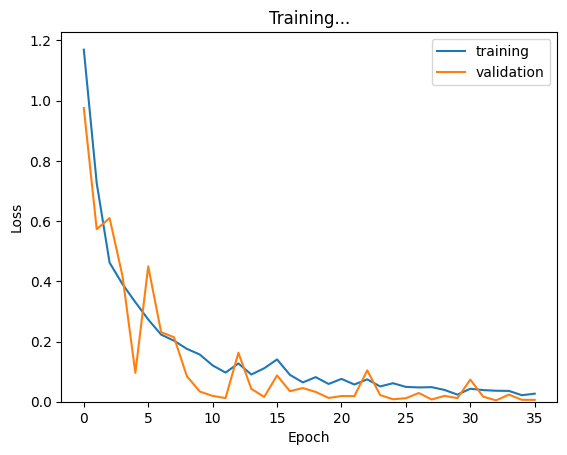

Early stopping


In [ ]:
# Train function

import realtime_graph as graph
import gc

epochresults = []
epoch_valloss = 0
graph.startplot()


for epoch in range(epochs):

    running_loss = 0.0
    running_valloss = 0.0

    myresnetmodel.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------

        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    myresnetmodel.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss
    for idx, data in enumerate(testloader):
        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        # record validation loss
        running_valloss += loss.item()


    epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])


    graph.realtimeplot(epochresults)


    if epoch_vallos_previous-limit < epoch_valloss < epoch_vallos_previous+limit and epoch_loss<0.05:
        print("Early stopping")
        break

In [ ]:
dataset_path_test = "/content/drive/MyDrive/appel_crop_selectnew/Test"
transform = ToTensor()
dataset_test = ImageFolder(dataset_path_test, transform=transform)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=test_batchsize, shuffle=False)

In [ ]:
print(dataset_path_test)

/content/drive/MyDrive/appel_crop_selectnew/Test


In [ ]:
dataset_test.class_to_idx

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [ ]:
# Get the length of the data in dataset_test_loader
num_images = len(dataset_test_loader.dataset)
print(f"Number of images: {num_images}")

Number of images: 117


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    #for idx, data in enumerate(dataset_test_loader):
    for data in dataset_test_loader:
        inputs, labels = data

        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myresnetmodel.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print predicted and label values
        #for i in range(len(labels)):
        #   print(f"Predicted: {predicted[i]}, Label: {labels[i]}")

        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[predicted[i]][labels[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)
print(total)

Accuracy of the network on the test images: 77 %
Confusion Matrix:
[[21.  5.  2.  1.]
 [ 0. 14.  1.  0.]
 [ 0.  1. 32.  2.]
 [ 7.  4.  3. 24.]]
117


In [ ]:
width, height = confusion_matrix.shape
normtotal = 0
normcorrect = confusion_matrix[1][1]
for i in range(height):
    normtotal += confusion_matrix[i][1]

accuracy_normal_apple = round((normcorrect/normtotal)*100, 1)

print('Accuracy on Normal Apples:'+str(accuracy_normal_apple)+'%')

Accuracy on Normal Apples:58.3%


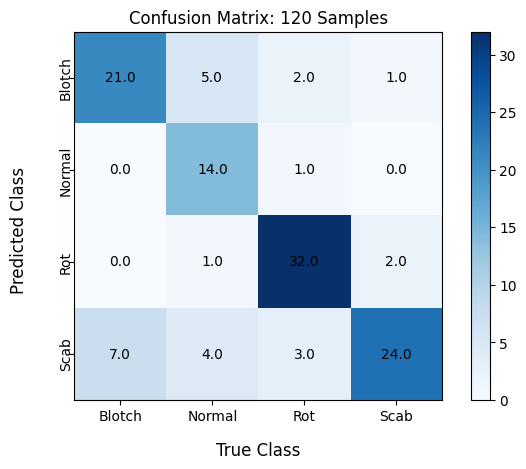

In [ ]:
# Define class labels
class_labels = ['Blotch', 'Normal', 'Rot', 'Scab']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(confusion_matrix, cmap='Blues')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis ticks and labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticklabels(class_labels, fontsize=10)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=90, ha="center",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Set the title
ax.set_title("Confusion Matrix: 120 Samples")

# Display axis meaning
ax.text(0.5, -0.15, f"True Class", transform=ax.transAxes,
        fontsize=12, ha='center')
ax.text(-0.15, 0.3, f"Predicted Class", rotation=90, transform=ax.transAxes,
        fontsize=12, ha='center')


# Show the figure
plt.tight_layout()
plt.show()


In [ ]:

torch.save(myresnetmodel, 'apple_resnet_classifier.pt')